/home/sgillen/work/lorenz/data2/sg_ppo_fixed/deep_fixed_2/seed2224069849ppo--4-8_12-39
/home/sgillen/work/lorenz/data2/sg_ppo_fixed/deep_fixed_2/seed952971468ppo--4-8_12-39
/home/sgillen/work/lorenz/data2/sg_ppo_fixed/deep_fixed_2/seed3797299562ppo--4-8_12-39
/home/sgillen/work/lorenz/data2/sg_ppo_fixed/deep_fixed_2/seed2597037600ppo--4-8_12-39
/home/sgillen/work/lorenz/data2/sg_ppo_fixed/deep_fixed_2/seed567847012ppo--4-8_12-39
/home/sgillen/work/lorenz/data2/sg_ppo_fixed/deep_fixed_2/seed2197272387ppo--4-8_12-39
/home/sgillen/work/lorenz/data2/sg_ppo_fixed/deep_fixed_2/seed1196293557ppo--4-8_12-39
/home/sgillen/work/lorenz/data2/sg_ppo_fixed/deep_fixed_2/seed2086740717ppo--4-8_12-39


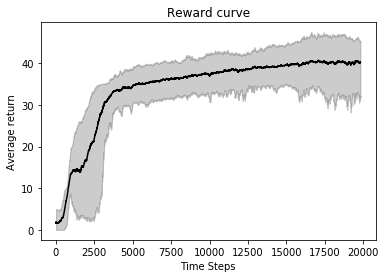

In [53]:
import seagul.envs
from seagul.rl.run_utils import load_workspace
from seagul.plot import smooth_bounded_curve

import random
import gym
import numpy as np
from numpy import pi
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os
import itertools

dtype = np.float32
#script_dir = os.path.dirname(__file__)
#trial_dir = script_dir + "/data2/sg_ppo_fixed/deep_longer_2"
trial_dir = "/home/sgillen/work/lorenz/data2/sg_ppo_fixed/fix"

ws_list = []
model_list = []
max_size = 0
for entry in os.scandir(trial_dir):
    model, env, args, ws = load_workspace(entry.path)
    #plt.plot(ws["raw_rew_hist"])
    #plt.show(); plt.figure()
    if len(ws["raw_rew_hist"]) > max_size:
        max_size = len(ws["raw_rew_hist"])

    print(entry.path)
    ws_list.append(ws)
    model_list.append(model)

rewards = np.zeros((max_size, len(ws_list)))

for i, ws in enumerate(ws_list):
    # plt.plot(ws["raw_rew_hist"])
    # plt.figure()
    # print(len(ws["raw_rew_hist"]))

    rewards[:len(ws["raw_rew_hist"]), i] = np.array(ws["raw_rew_hist"])

fig, ax = smooth_bounded_curve(rewards, window=100)


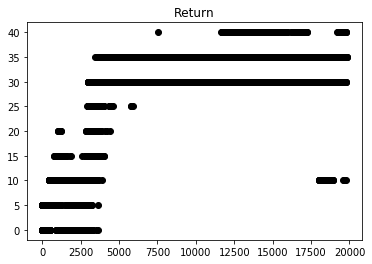

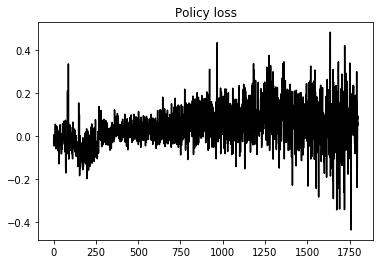

Text(0.5,1,'Value loss')

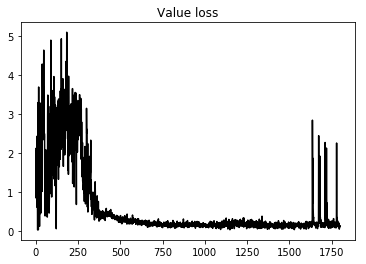

In [74]:
# %%

ws = ws_list[-3]
model = model_list[-3]

plt.plot(ws['raw_rew_hist'], 'ko')
plt.title('Return')
plt.show();plt.figure()

plt.plot(ws['pol_loss_hist'], 'k')
plt.title('Policy loss')
plt.show(); plt.figure()

plt.plot(ws['val_loss_hist'], 'k')
plt.title('Value loss')

In [75]:
# %%
env = gym.make(ws['env_name'], **ws['env_config'])

def do_rollout(init_point):
    obs = env.reset(init_point)
    obs = np.array(obs, dtype=dtype)

    action_hist = []
    obs_hist = []
    reward_hist = []
    logp_hist = []

    done = False
    while not done:
        sampled_actions, val, _, logp = model.step(obs.reshape(1, -1))
        actions = sampled_actions.detach().reshape(-1)

        obs, reward, done, _ = env.step(np.asarray(actions))
        obs = np.array(obs, dtype=dtype)

        action_hist.append(np.copy(actions))
        obs_hist.append(np.copy(obs))
        reward_hist.append(np.copy(reward))
        logp_hist.append(logp.detach())

    action_hist = np.stack(action_hist)
    obs_hist = np.stack(obs_hist)
    reward_hist = np.stack(reward_hist)
    logp_hist = np.stack(logp_hist)

    return obs_hist, action_hist, reward_hist, logp_hist.reshape(-1, logp_hist.shape[1])


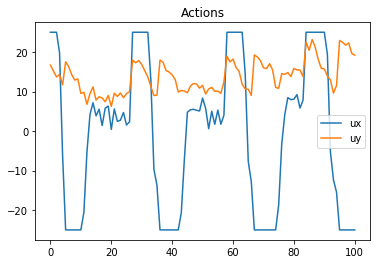

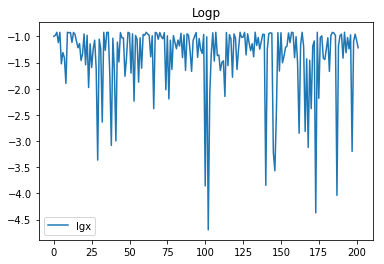

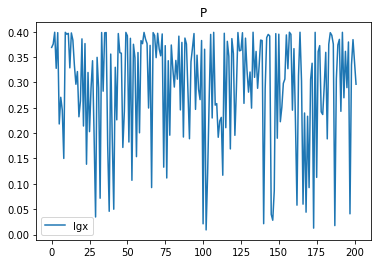

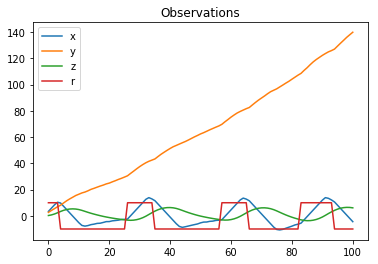

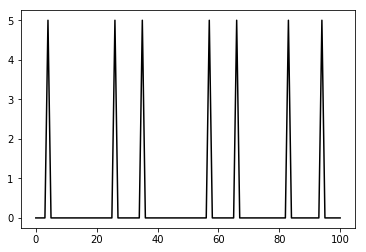

In [76]:
# X0 = np.array([1, 1,.3])
X0 = np.random.random(3)


obs_hist, action_hist, reward_hist, logp_hist = do_rollout(X0)

plt.plot(np.clip(action_hist, -env.action_max, env.action_max))
plt.title('Actions')
plt.legend(['ux', 'uy'])
plt.show(); plt.figure()

plt.plot(logp_hist)
plt.title('Logp')
plt.legend(['lgx', 'lqy'])
plt.show(); plt.figure()

plt.plot(np.exp(logp_hist))
plt.title('P')
plt.legend(['lgx', 'lqy'])
plt.show(); plt.figure()

plt.plot(obs_hist)
plt.title('Observations')
plt.legend(['x', 'y', 'z', 'r'])
plt.show(); plt.figure()

plt.plot(reward_hist, 'k')
plt.show(); plt.figure()

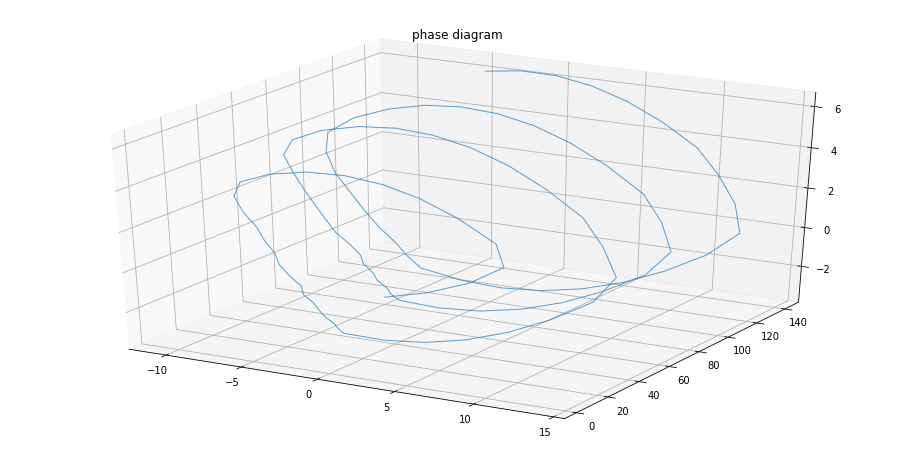

In [77]:
obs_arr = np.stack(obs_hist)
x = obs_arr[:, 0]
y = obs_arr[:, 1]
z = obs_arr[:, 2]

fig = plt.figure(figsize=(16, 8))
ax = fig.gca(projection='3d')
ax.plot(x, y, z, alpha=0.7, linewidth=1)
ax.set_title('phase diagram')
plt.show(); plt.figure()


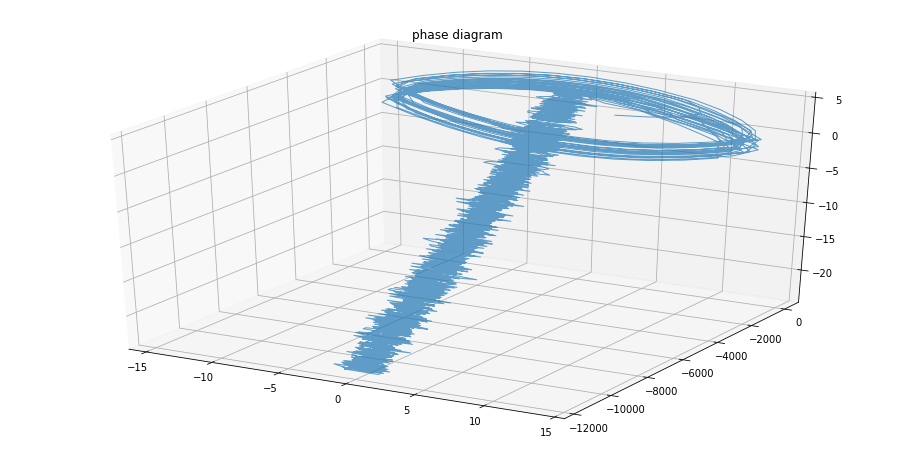

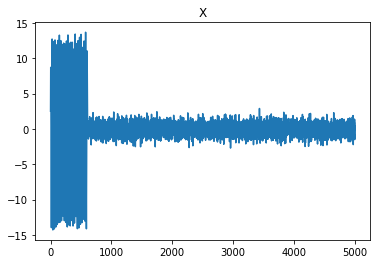

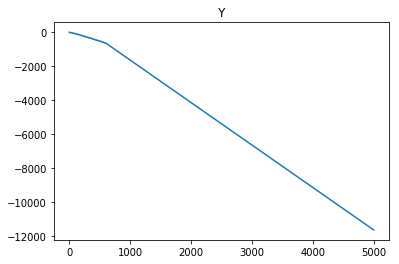

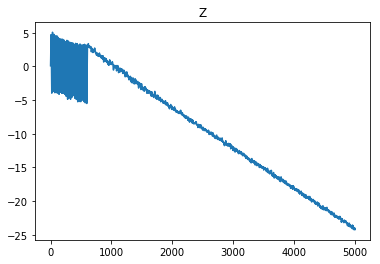

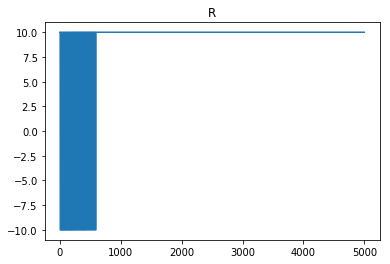

In [52]:
env = gym.make(ws['env_name'], **ws['env_config'])
num_steps = env.num_steps
env.num_steps = 5000
obs_hist, _, _,_ = do_rollout(np.array([0, 0, 0]))
limit_set = obs_hist[4900:, :]
env.num_steps = num_steps

obs_arr= np.stack(obs_hist)
x = obs_arr[:, 0]
y = obs_arr[:, 1]
z = obs_arr[:, 2]
r = obs_arr[:, 3]


fig = plt.figure(figsize=(16, 8))
ax = fig.gca(projection='3d')
ax.plot(x, y, z, alpha=0.7, linewidth=1)
ax.set_title('phase diagram')
plt.show(); plt.figure()

plt.plot(x)
plt.title("X")
plt.show(); plt.figure()
plt.plot(y)
plt.title("Y")
plt.show(); plt.figure()
plt.plot(z)
plt.title("Z")
plt.show(); plt.figure()
plt.plot(r)
plt.title("R")
plt.show(); plt.figure()

In [15]:
seed_point = np.array(obs_hist[-1, :3])
dx = dy = dz = 1e-6

deltas = itertools.product([-dx, dx, 0], [-dy, dy, 0], [-dz, dz, 0])
deltas = np.array(list(deltas))

init_points = seed_point + deltas

final_points = np.zeros_like(init_points)
min_points = np.zeros_like(init_points)
trajs = np.zeros((init_points.shape[0], env.num_steps + 1, init_points.shape[1]))

for i, init_point in enumerate(init_points):
    obs_hist, act_hist, rew_hist, _ = do_rollout(init_point)
    trajs[i, :] = obs_hist[:, :3]

In [16]:
num_trajs = trajs.shape[0]

min_x = np.zeros((num_trajs, num_steps))
min_y = np.zeros((num_trajs, num_steps))
min_z = np.zeros((num_trajs, num_steps))
min_d = np.zeros((num_trajs, num_steps))
min_d = np.zeros((num_trajs, num_steps))
min_dxz = np.zeros((num_trajs, num_steps))

for i in range(trajs.shape[0]):
    for t in range(num_steps):
        min_x[i, t] = np.min(np.linalg.norm((trajs[i, t, 0] - limit_set[:, 0]).reshape(1, -1), axis=0))
        min_y[i, t] = np.min(np.linalg.norm((trajs[i, t, 1] - limit_set[:, 1]).reshape(1, -1), axis=0))
        min_z[i, t] = np.min(np.linalg.norm((trajs[i, t, 2] - limit_set[:, 2]).reshape(1, -1), axis=0))
        min_d[i, t] = np.min(np.linalg.norm(trajs[i, t, :] - limit_set[:, :3], axis=1))
        min_dxz[i, t] = np.min(np.linalg.norm(trajs[i, t, 0::2] - limit_set[:, 0::2], axis=1))


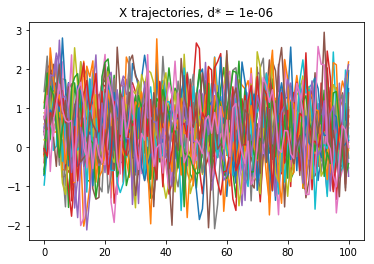

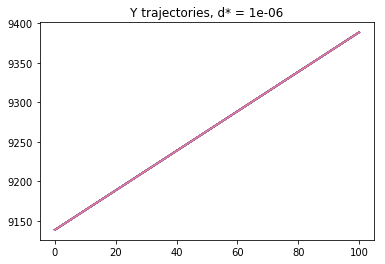

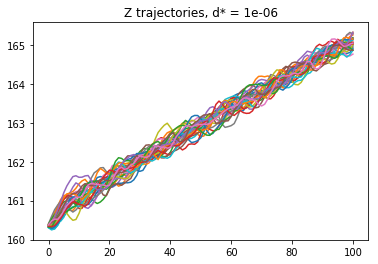

In [17]:
for i, _ in enumerate(trajs[:, 0, 0]):
    plt.plot(trajs[i, :, 0])
    plt.title("X trajectories, d* = " + str(dx))
plt.show(); plt.figure()

for i, _ in enumerate(trajs[:, 0, 0]):
    plt.plot(trajs[i, :, 1])
    plt.title("Y trajectories, d* = " + str(dy))
plt.show(); plt.figure()

for i, _ in enumerate(trajs[:, 0, 0]):
    plt.plot(trajs[i, :, 2])
    plt.title("Z trajectories, d* = " + str(dz))
plt.show(); plt.figure()

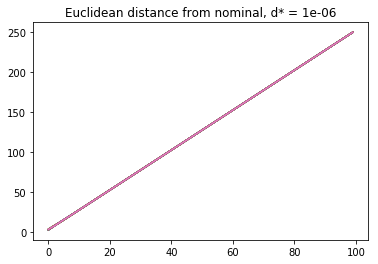

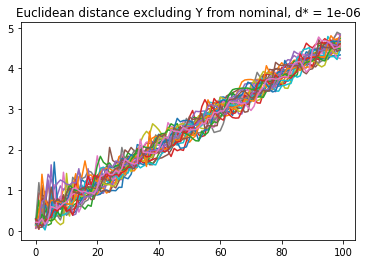

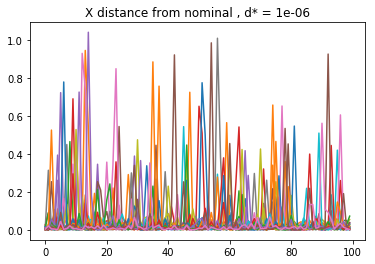

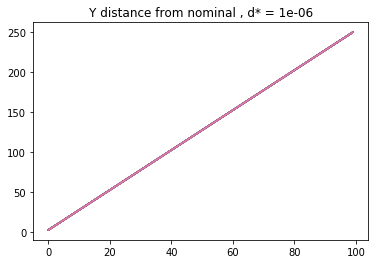

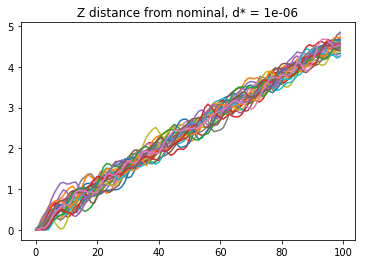

In [18]:
for i, _ in enumerate(trajs[:, 0, 0]):
    plt.plot(min_d[i, :])
    plt.title("Euclidean distance from nominal, d* = " + str(dx))
plt.show(); plt.figure()

for i, _ in enumerate(trajs[:, 0, 0]):
    plt.plot(min_dxz[i, :])
    plt.title("Euclidean distance excluding Y from nominal, d* = " + str(dx))
plt.show(); plt.figure()

for i, _ in enumerate(trajs[:, 0, 0]):
    plt.plot(min_x[i, :])
    plt.title("X distance from nominal , d* = " + str(dx))
plt.show(); plt.figure()

for i, _ in enumerate(trajs[:, 0, 0]):
    plt.plot(min_y[i, :])
    plt.title("Y distance from nominal , d* = " + str(dx))
plt.show(); plt.figure()

for i, _ in enumerate(trajs[:, 0, 0]):
    plt.plot(min_z[i, :])
    plt.title("Z distance from nominal, d* = " + str(dx))
plt.show(); plt.figure()

# Global point analysis 

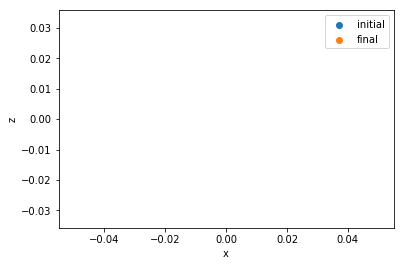

In [19]:
env = gym.make(ws['env_name'], **ws['env_config'])
num_points = int(0)
env.num_steps = 100

init_points = np.random.uniform(low=np.array([-10, -10, -10]), high=np.array([10, 10, 10]), size=(num_points, 3))
final_points = np.zeros_like(init_points)
trajs = np.zeros((init_points.shape[0], env.num_steps + 1, init_points.shape[1]))

for i, init_point in enumerate(init_points):
    obs_hist, act_hist, rew_hist, _ = do_rollout(init_point)
    trajs[i, :] = obs_hist[:, :3]
    final_points[i, :] = obs_hist[-1, :3]

# %%

plt.scatter(init_points[:, 0], init_points[:, 2])
plt.scatter(final_points[:, 0], final_points[:, 2])
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('z')
plt.legend(['initial', 'final'])
plt.show(); plt.figure()

# Network output analysis


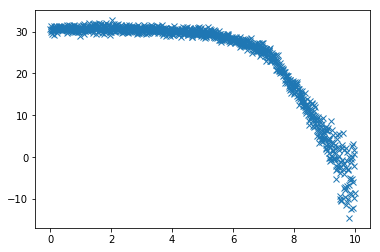

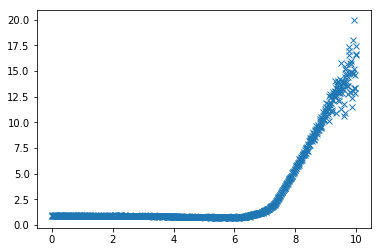

In [20]:
num_points = 1000

obs = np.array([0.0, 0.0, 0.0, 10.0])

ys = np.linspace(-10, 10, num_points)
xs = np.linspace(0, 10, num_points)

action_arr = np.zeros((num_points, 2))
var = np.zeros((num_points, 2))
logp = np.zeros((num_points, 2))
vf_preds = np.zeros((num_points, 1))

for i, xy in enumerate(zip(xs, ys)):
    x = xy[0];
    y = xy[1]

    obs[0] = x;  # obs[1] = y

    obs = np.array(obs, dtype=dtype)
    sampled_actions, val, _, lp = model.step(obs.reshape(1, -1))

    actions = sampled_actions.detach()
    var[i] = [.7, .7]
    logp[i] = lp.detach()
    vf_preds[i] = val.detach()

    action_arr[i] = actions

plt.plot(xs, action_arr[:, 0], 'x')
plt.show(); plt.figure()

plt.plot(xs, action_arr[:, 1], 'x')
plt.show(); plt.figure()


# Meshing dimensionality analysis

In [22]:
env = gym.make(ws['env_name'], **ws['env_config'])
num_steps = env.num_steps
env.num_steps = 5000
obs_hist, _, _,_ = do_rollout(np.array([0, 0, 0]))
limit_set = obs_hist[4900:, :]
env.num_steps = num_steps


In [23]:
def removearray(L, arr):
    ind = 0
    size = len(L)
    while ind != size and not np.array_equal(L[ind], arr):
        ind += 1
    if ind != size:
        L.pop(ind)
    else:
        raise ValueError('array not found in list.')


d_min = 1e-8;
d_max = 40
d_vals = np.linspace(d_min, d_max, 2000)
mesh_sizes = []

for d in d_vals:
    orig = []
    mesh = []

    for point in limit_set[:, :3]:
        orig.append(point)

    while True:
        sample = random.sample(orig, 1)[0]
        removearray(orig, sample)
        mesh.append(sample)

        for item in orig:
            if (np.linalg.norm(sample - item) < d):
                removearray(orig, item)

        if len(orig) == 0:
            break

    mesh_sizes.append(len(mesh))

In [5]:
import scipy.optimize as opt

lin_begin = 5;
lin_end = 450
xdata = np.array(d_vals[lin_begin:lin_end])
ydata = np.array(mesh_sizes[lin_begin:lin_end])

# plt.plot(xdata, ydata, 'bx')
plt.plot(d_vals, mesh_sizes, 'gx--', alpha=.2)
# plt.legend(['linear region guess', 'all data'])
plt.xlabel('d')
plt.ylabel('log(Points in mesh)')
plt.yscale('log')
plt.xscale('log')
plt.gca().xaxis.grid(True, which='both')  # minor grid on too
plt.gca().yaxis.grid(True, which='both')  # minor grid on too

plt.show(); plt.figure()

plt.plot(xdata, ydata, 'bx')
plt.plot(d_vals, mesh_sizes, 'gx--', alpha=.2)
plt.legend(['linear region guess', 'all data'])
plt.xlabel('d')
plt.ylabel('log(Points in mesh)')
plt.yscale('log')
plt.xscale('log')
plt.gca().xaxis.grid(True, which='both')  # minor grid on too
plt.gca().yaxis.grid(True, which='both')  # minor grid on too
plt.show(); plt.figure()

NameError: name 'np' is not defined

In [ ]:
def f(x, m, b):
    return m * x + b

popt, pcov = opt.curve_fit(f, np.log(xdata), np.log(ydata))

plt.plot(np.log(xdata), np.log(ydata), 'bx', alpha=.5)
plt.plot(np.log(xdata), f(np.log(xdata), *popt), 'r--')
plt.legend(['linear region guess', 'fit: m*x + b,  m=%5.3f, b=%5.3f' % tuple(popt)])
plt.gca().xaxis.grid(True)  # minor grid on too
plt.gca().yaxis.grid(True)  # minor grid on too
plt.show(); plt.figure()
